In [1]:
import os
import sys; sys.path.append("/home/ovtin/cernbox/HHggbb/HHbbgg_ETH_devel/Training/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)
import preprocessing_utils as preprocessing
reload(preprocessing)
import plotting_utils as plotting
reload(plotting)
import optimization_utils as optimization
reload(optimization)
import postprocessing_utils as postprocessing
reload(postprocessing)

from sklearn.externals import joblib
loaded_model_A = joblib.load(os.path.expanduser('/home/ovtin/cernbox/HHggbb/HHbbgg_ETH_devel/Training/output_files/simlple_binary_st.pkl'))
loaded_model_B = joblib.load(os.path.expanduser('/home/ovtin/cernbox/HHggbb/HHbbgg_ETH_devel/Training/output_files/simlple_binary_st.pkl'))
#loaded_model_B = joblib.load(os.path.expanduser('/home/ovtin/cernbox/HHggbb/HHbbgg_ETH_devel/Training/output_files/simlple_binary_st_ptmgg_pt_mjj_drother.pkl'))
#loaded_model_D = joblib.load(os.path.expanduser('/home/ovtin/cernbox/HHggbb/HHbbgg_ETH_devel/Training/output_files/simlple_Test_binary.pkl'))
#loaded_model_E = joblib.load(os.path.expanduser('/home/ovtin/cernbox/HHggbb/HHbbgg_ETH_devel/Training/output_files/simlple_Test_binary.pkl'))

print loaded_model_A

Welcome to JupyROOT 6.13/02
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1e-05, missing=nan, n_estimators=2000,
       n_jobs=1, nthread=20, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, seed=0,
       silent=True, subsample=1)


In [2]:
ntuples = '2016'
# "%" sign allows to interpret the rest as a system command
%env data=$utils.IO.ldata$ntuples
files = ! ls $data | sort -t_ -k 3 -n
#signal = [s for s in files if "output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph_2016_ptmjj.root" in s]
#bkgr = [s for s in files if "DoubleEG_2016_ptmjj.root" in s]
signal = [s for s in files if "output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph_2016.root" in s]
bkgr = [s for s in files if "DoubleEG_2016.root" in s]

utils.IO.add_signal(ntuples,signal,1)
utils.IO.add_background(ntuples,bkgr,-1)

ntuples = '2017'
# "%" sign allows to interpret the rest as a system command
%env data=$utils.IO.ldata$ntuples
files = ! ls $data | sort -t_ -k 3 -n
#signal = [s for s in files if "output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph_2017_ptmjj.root" in s]
#bkgr = [s for s in files if "DoubleEG_2017_ptmjj.root" in s]
signal = [s for s in files if "output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph_2017.root" in s]
bkgr = [s for s in files if "DoubleEG_2017.root" in s]
utils.IO.add_signal(ntuples,signal,-1)
utils.IO.add_background(ntuples,bkgr,-1)


for i in range(len(utils.IO.backgroundName)):        
    print "using background file n."+str(i)+": "+utils.IO.backgroundName[i]
for i in range(len(utils.IO.signalName)):    
    print "using signal file n."+str(i)+": "+utils.IO.signalName[i]

env: data=/home/ovtin/cernbox/HHggbb/HHbbgg_ETH_devel/Training/2016
env: data=/home/ovtin/cernbox/HHggbb/HHbbgg_ETH_devel/Training/2017
using background file n.0: /home/ovtin/cernbox/HHggbb/HHbbgg_ETH_devel/Training/2016/DoubleEG_2016.root
using background file n.1: /home/ovtin/cernbox/HHggbb/HHbbgg_ETH_devel/Training/2017/DoubleEG_2017.root
using signal file n.0: /home/ovtin/cernbox/HHggbb/HHbbgg_ETH_devel/Training/2016/output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph_2016.root
using signal file n.1: /home/ovtin/cernbox/HHggbb/HHbbgg_ETH_devel/Training/2017/output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph_2017.root


In [3]:
#use noexpand for root expressions, it needs this file https://github.com/ibab/root_pandas/blob/master/root_pandas/readwrite.py
#standart of input values 
branch_names = 'absCosThetaStar_CS,absCosTheta_bb,absCosTheta_gg,PhoJetMinDr,leadingJet_DeepCSV,subleadingJet_DeepCSV,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverM,diphotonCandidatePtOverdiHiggsM,dijetCandidatePtOverdiHiggsM,noexpand:leadingJet_bRegNNResolution/leadingJet_pt,noexpand:subleadingJet_bRegNNResolution/subleadingJet_pt,noexpand:sigmaMJets/Mjj,rho'.split(",")
branch_names = [c.strip() for c in branch_names]
print branch_names

import pandas as pd
import root_pandas as rpd
from root_numpy import root2array, list_trees

#print list_trees('/home/ovtin/cernbox/HHggbb/HHbbgg_ETH_devel/Training/2016/output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph.root')
for i in range(len(utils.IO.backgroundName)):        
    print list_trees(utils.IO.backgroundName[i])
        
preprocessing.set_signals("GluGluToHHTo2B2G_node_SM_13TeV_madgraph_13TeV_DoubleHTag_0",branch_names,True)
preprocessing.set_backgrounds("Data_13TeV_DoubleHTag_0",branch_names,True) 
X_bkg,y_bkg,weights_bkg,X_sig,y_sig,weights_sig=preprocessing.set_variables(branch_names)

#relative weighting between components of one class is kept, all classes normalized to the same
#weights_sig=preprocessing.weight_signal_with_resolution(weights_sig,y_sig)
weights_bkg,weights_sig=preprocessing.normalize_process_weights(weights_bkg,y_bkg,weights_sig,y_sig)

X_bkg,y_bkg,weights_bkg = preprocessing.randomize(X_bkg,y_bkg,weights_bkg)
X_sig,y_sig,weights_sig = preprocessing.randomize(X_sig,y_sig,weights_sig)

print X_bkg.shape
print y_bkg.shape
#bbggTrees have by default signal and CR events, let's be sure that we clean it
X_bkg,y_bkg,weights_bkg,X_sig,y_sig,weights_sig=preprocessing.clean_signal_events(X_bkg,y_bkg,weights_bkg,X_sig,y_sig,weights_sig)
print X_bkg.shape
print y_bkg.shape

y_total_train = preprocessing.get_total_training_sample(y_sig,y_bkg).ravel()
X_total_train = preprocessing.get_total_training_sample(X_sig,X_bkg)

y_total_test = preprocessing.get_total_test_sample(y_sig,y_bkg).ravel()
X_total_test = preprocessing.get_total_test_sample(X_sig,X_bkg)

w_total_train = preprocessing.get_total_training_sample(weights_sig,weights_bkg).ravel()
w_total_test = preprocessing.get_total_test_sample(weights_sig,weights_bkg).ravel()

['absCosThetaStar_CS', 'absCosTheta_bb', 'absCosTheta_gg', 'PhoJetMinDr', 'leadingJet_DeepCSV', 'subleadingJet_DeepCSV', 'leadingPhotonSigOverE', 'subleadingPhotonSigOverE', 'sigmaMOverM', 'diphotonCandidatePtOverdiHiggsM', 'dijetCandidatePtOverdiHiggsM', 'noexpand:leadingJet_bRegNNResolution/leadingJet_pt', 'noexpand:subleadingJet_bRegNNResolution/subleadingJet_pt', 'noexpand:sigmaMJets/Mjj', 'rho']
['Data_13TeV_DoubleHTag_0']
['Data_13TeV_DoubleHTag_0']
using tree:GluGluToHHTo2B2G_node_SM_13TeV_madgraph_13TeV_DoubleHTag_0
(508299, 15)
(508299, 1)
(508299, 15)
(508299, 1)


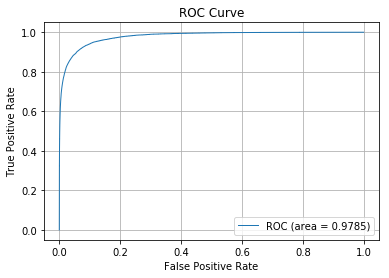

In [4]:
fpr_gJ_A,tpr_gJ_A = plotting.plot_roc_curve(X_total_test,y_total_test,loaded_model_A,outString="xgbrA")

In [5]:
#fpr_gJ_B,tpr_gJ_B = plotting.plot_roc_curve(X_total_test,y_total_test,loaded_model_B,outString="xgbrB")

In [6]:
#fpr_gJ_D,tpr_gJ_D = plotting.plot_roc_curve(X_total_test,y_total_test,loaded_model_D,outString="xgbrD")

In [7]:
#fpr_gJ_E,tpr_gJ_E = plotting.plot_roc_curve(X_total_test,y_total_test,loaded_model_E,outString="xgbrE")

In [16]:
utils.IO.backgroundName =[]
utils.IO.signalName = []
ntuples = '2016'
# "%" sign allows to interpret the rest as a system command
%env data=$utils.IO.ldata$ntuples
files = ! ls $data | sort -t_ -k 3 -n
signal = [s for s in files if "output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph_2016_ptmjj.root" in s]
bkgr = [s for s in files if "DoubleEG_2016_ptmjj.root" in s]

utils.IO.add_signal(ntuples,signal,2)
utils.IO.add_background(ntuples,bkgr,-2)

ntuples = '2017'
# "%" sign allows to interpret the rest as a system command
%env data=$utils.IO.ldata$ntuples
files = ! ls $data | sort -t_ -k 3 -n
signal = [s for s in files if "output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph_2017_ptmjj.root" in s]
bkgr = [s for s in files if "DoubleEG_2017_ptmjj.root" in s]
utils.IO.add_signal(ntuples,signal,-2)
utils.IO.add_background(ntuples,bkgr,-2)


for i in range(len(utils.IO.backgroundName)):        
    print "using background file n."+str(i)+": "+utils.IO.backgroundName[i]
for i in range(len(utils.IO.signalName)):    
    print "using signal file n."+str(i)+": "+utils.IO.signalName[i]

env: data=/home/ovtin/cernbox/HHggbb/HHbbgg_ETH_devel/Training/2016
env: data=/home/ovtin/cernbox/HHggbb/HHbbgg_ETH_devel/Training/2017
using background file n.0: /home/ovtin/cernbox/HHggbb/HHbbgg_ETH_devel/Training/2016/DoubleEG_2016_ptmjj.root
using background file n.1: /home/ovtin/cernbox/HHggbb/HHbbgg_ETH_devel/Training/2017/DoubleEG_2017_ptmjj.root
using signal file n.0: /home/ovtin/cernbox/HHggbb/HHbbgg_ETH_devel/Training/2016/output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph_2016_ptmjj.root
using signal file n.1: /home/ovtin/cernbox/HHggbb/HHbbgg_ETH_devel/Training/2017/output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph_2017_ptmjj.root


In [20]:
#use noexpand for root expressions, it needs this file https://github.com/ibab/root_pandas/blob/master/root_pandas/readwrite.py
branch_names = 'absCosThetaStar_CS,absCosTheta_bb,absCosTheta_gg,PhoJetMinDr,leadingJet_DeepCSV,subleadingJet_DeepCSV,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverM,diphotonCandidatePtOverdiHiggsM,dijetCandidatePtOverdiHiggsM,noexpand:leadingJet_bRegNNResolution/leadingJet_pt,noexpand:subleadingJet_bRegNNResolution/subleadingJet_pt,noexpand:sigmaMJets/Mjj,rho,noexpand:leadingPhoton_pt/CMS_hgg_mass,noexpand:subleadingPhoton_pt/CMS_hgg_mass,noexpand:leadingJet_pt/Mjj,noexpand:subleadingJet_pt/Mjj,PhoJetotherDr'.split(",")
branch_names = [c.strip() for c in branch_names]
print branch_names

import pandas as pd
import root_pandas as rpd
from root_numpy import root2array, list_trees

for i in range(len(utils.IO.backgroundName)):        
    print list_trees(utils.IO.backgroundName[i])
        
preprocessing.set_signals("GluGluToHHTo2B2G_node_SM_13TeV_madgraph_13TeV_DoubleHTag_0",branch_names,True)
preprocessing.set_backgrounds("Data_13TeV_DoubleHTag_0",branch_names,True) 
X_bkg,y_bkg,weights_bkg,X_sig,y_sig,weights_sig=preprocessing.set_variables(branch_names)

#relative weighting between components of one class is kept, all classes normalized to the same
#weights_sig=preprocessing.weight_signal_with_resolution(weights_sig,y_sig)
weights_bkg,weights_sig=preprocessing.normalize_process_weights(weights_bkg,y_bkg,weights_sig,y_sig)

X_bkg,y_bkg,weights_bkg = preprocessing.randomize(X_bkg,y_bkg,weights_bkg)
X_sig,y_sig,weights_sig = preprocessing.randomize(X_sig,y_sig,weights_sig)

print X_bkg.shape
print y_bkg.shape
#bbggTrees have by default signal and CR events, let's be sure that we clean it
X_bkg,y_bkg,weights_bkg,X_sig,y_sig,weights_sig=preprocessing.clean_signal_events(X_bkg,y_bkg,weights_bkg,X_sig,y_sig,weights_sig)
print X_bkg.shape
print y_bkg.shape

y_total_train = preprocessing.get_total_training_sample(y_sig,y_bkg).ravel()
X_total_train = preprocessing.get_total_training_sample(X_sig,X_bkg)

y_total_test = preprocessing.get_total_test_sample(y_sig,y_bkg).ravel()
X_total_test = preprocessing.get_total_test_sample(X_sig,X_bkg)

w_total_train = preprocessing.get_total_training_sample(weights_sig,weights_bkg).ravel()
w_total_test = preprocessing.get_total_test_sample(weights_sig,weights_bkg).ravel()

['absCosThetaStar_CS', 'absCosTheta_bb', 'absCosTheta_gg', 'PhoJetMinDr', 'leadingJet_DeepCSV', 'subleadingJet_DeepCSV', 'leadingPhotonSigOverE', 'subleadingPhotonSigOverE', 'sigmaMOverM', 'diphotonCandidatePtOverdiHiggsM', 'dijetCandidatePtOverdiHiggsM', 'noexpand:leadingJet_bRegNNResolution/leadingJet_pt', 'noexpand:subleadingJet_bRegNNResolution/subleadingJet_pt', 'noexpand:sigmaMJets/Mjj', 'rho', 'noexpand:leadingPhoton_pt/CMS_hgg_mass', 'noexpand:subleadingPhoton_pt/CMS_hgg_mass', 'noexpand:leadingJet_pt/Mjj', 'noexpand:subleadingJet_pt/Mjj', 'PhoJetotherDr']
['Data_13TeV_DoubleHTag_0']
['Data_13TeV_DoubleHTag_0']


IndexError: list index out of range

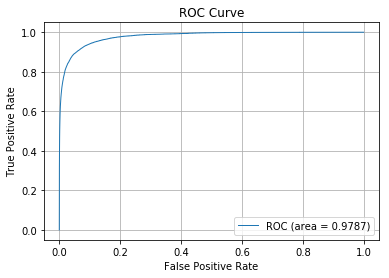

In [11]:
fpr_gJ_B,tpr_gJ_B = plotting.plot_roc_curve(X_total_test,y_total_test,loaded_model_B,outString="xgbrB")

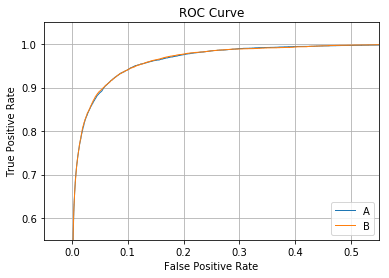

In [12]:
import matplotlib.pyplot as plt
plt.show()

plt.plot(fpr_gJ_A, tpr_gJ_A, lw=1, label='A')
plt.plot(fpr_gJ_B, tpr_gJ_B, lw=1, label='B')
#plt.plot(fpr_gJ_D, tpr_gJ_D, lw=1, label='C')
#plt.plot(fpr_gJ_E, tpr_gJ_E, lw=1, label='D')


plt.xlim([-0.05, 0.55])
plt.ylim([0.55, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()

#plt.show()

outString = "comparison_resWeight_optimization_gJ_zoom"
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".png")
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".pdf")